<a href="https://colab.research.google.com/gist/arun477/726843622e3ac4c178856c4666c2663b/article_text_to_keywords.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk
!pip install pymed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from pymed import PubMed
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# english stop words
eng_stop_words=set(stopwords.words('english'))

In [4]:
pubmed = PubMed(tool="MyTool", email="coolarun477@gmail.com")
results = pubmed.query("covid", max_results=500)
results = [ele.toDict() for ele in results]

In [5]:
print('total documents: ', len(results))

total documents:  500


In [6]:
# keep document wich only has keywords
results_with_keywords = [ele for ele in results if len(ele.get('keywords', []))>0]

In [7]:
print('total documents with keywords: ', len(results_with_keywords))

total documents with keywords:  372


In [8]:
# combine the abstract, title, conclusions all into single text blocks
# and take set of keywords and attach this combined textblock to each keyword in that document
data = []
for doc in results_with_keywords:
  title = doc.get('title') or ''
  abstract = doc.get('abstract') or ''
  conclusions = doc.get('conclusions') or ''
  combined_text = title +  ' ' + abstract + ' ' + conclusions
  keywords = list(set(doc.get('keywords', [])))
  for keyword in keywords:
    data.append({
        "keyword": keyword,
        "text": combined_text
    })

In [9]:
print('total data points: ', len(data))

total data points:  1948


In [10]:
def clean_text(text):
  # remove line space remove quotes and make it lower case
  text = text.strip().replace('\n', ' ').replace('"', '').replace("'", '').lower()
  # remove english stop words
  text = filter(lambda w: not w in eng_stop_words,text.split())
  text = " ".join(text)
  return text

In [11]:
# goal is to build a model which will predict set of "important keywords" for the given text block

In [12]:
# vocabs
words = sorted(list(set(" ".join([clean_text(ele['text']) for ele in data]).split(' '))))
keywords = sorted(list(set(" ".join([clean_text(ele['keyword']) for ele in data]).split(' '))))
# print(keywords[1000])
words += keywords
words = sorted(list(set(words)))
wtoi = {w:i+1 for i, w in enumerate(words)}
wtoi['.'] = 0
itow = {i:w for w, i in wtoi.items()}
n_vocab = len(itow)
print('len vocab: ', n_vocab)

len vocab:  14796


In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
random.seed(46)

In [14]:
# train, test, validation set
n1 = int(0.6*len(data))
n2 = int(0.8*len(data))
random.shuffle(data)

def get_batch_data(data):
  X, Y = [], []
  for d in data:
    text = d['text']
    keyword = d['keyword']
    context = []
    keyword_context = []
    for word in clean_text(text).split(' '):
      ix = wtoi[word]
      context.append(ix)
    
    for key in clean_text(keyword).split(' '):
      ix = wtoi[key]
      X.append(context) 
      Y.append(ix)
  
  # add the padding for the variable length
  max_len = max(len(x) for x in X)
  X_padded = []
  for x in X:
    padd_diff = abs(max_len-len(x))
    if max_len > 0:
      padding = [0] * padd_diff
    x = x + padding
    X_padded.append(x)
  
  print('max len: ', max_len)

  X = torch.tensor(X_padded)
  Y = torch.tensor(Y)

  return X, Y
    
Xtr, Ytr = get_batch_data(data[:n1])
Xdev, Ydev = get_batch_data(data[n1:n2])
Xte, Yte = get_batch_data(data[n2:])

max len:  538
max len:  538
max len:  538


In [26]:
# params
block_size = 538
batch_size = 32
embed_dim = 100
hidden_layer = 100
C = torch.randn(n_vocab + 1, embed_dim)
W1 = torch.randn(embed_dim*block_size, hidden_layer) * (5/3)/ (embed_dim*block_size)**0.5
b1 = torch.randn(hidden_layer) * 0.1
W2 = torch.randn(hidden_layer, n_vocab) * 0.1
b2 = torch.randn(n_vocab) * 0.1

In [27]:
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [31]:
isteps = []
iloss = []

In [ ]:
number_of_iterations = 5000

In [34]:
for i in range(number_of_iterations):
  # batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # forward pass
  emb = C[Xtr[ix]]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.01 if i < 5000 else 0.001
  for p in parameters:
    p.data += -lr * p.grad

  isteps.append(i)
  iloss.append(loss.item())

  if i % 1000 == 0:
    print('loss: ', loss.item())


loss:  6.444718837738037
loss:  6.346046447753906
loss:  6.113593101501465
loss:  5.694157123565674
loss:  6.2882981300354
loss:  5.749215602874756
loss:  5.945130348205566
loss:  6.240721225738525


KeyboardInterrupt: ignored

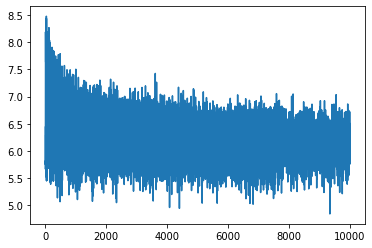

In [35]:
plt.plot(isteps, iloss)

In [37]:

def get_loss(loss_type):
    loss_type_map = {
        'train': [Xtr, Ytr],
        'dev': [Xdev, Ydev],
        'test': [Xte, Yte]
    }
    X = loss_type_map[loss_type][0]
    Y = loss_type_map[loss_type][1]
    
    # inference/loss
    emb = C[X]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    print(f'{loss_type} loss: {loss.item()}')

get_loss('train')
get_loss('dev')

train loss: 6.085864543914795
dev loss: 9.608205795288086


In [81]:
# prediction
for doc in Xdev[:5]:
  doc = doc.view(1, -1)
  doc_keywords = []
  for _ in range(5):
    # ix = torch.randint(0, Xdev.shape[0], (1,))
    # print(Xdev[ix].shape)
    # print(doc.shape)
    emb = C[doc]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    # pred_ix = torch.multinomial(torch.tensor([1/probs.shape[1]]*probs.shape[1]), num_samples=1).item()
    pred_ix = torch.multinomial(probs, num_samples=1).item()
    doc_keywords.append(itow[pred_ix])
  print(list(set(doc_keywords)))

['pandemic', 'convalescent', 'dementia', 'aging', 'policy']
['symptoms', 'stewardship', 'health', 'perceived', 'series']
['ethical', 'anxiety', 'molecular', 'model', 'system']
['neurodevelopmental', 'coronavirus', 'health', 'education', 'severe']
['demyelinating', 'indicators', 'aspects', 'transmission', 'covid-19']
